In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ast
import math
from advisor_client.client import *
client = AdvisorClient()

In [8]:
# get study
study_name = "optimal_jump4"
study = client.get_study_by_name(study_name)
print(study)

Id: 4, name: optimal_jump4, study_configuration: {"randomInitTrials": 20, "params": [{"parameterName": "jump_a", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_b", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_c", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_d", "type": "DOUBLE", "maxValue": 4.0, "minValue": 0}, {"parameterName": "opt_vel", "type": "DOUBLE", "maxValue": 6.0, "minValue": 3.0}], "goal": "MINIMIZE"}, algorithm: BayesianOptimization


Is study done: True
Best epoch: 240
Best trial: Id: 372, study_name: optimal_jump4, name: BayesianOptimizationTrial, parameter_values: {"opt_vel": 3.8062331674253143, "jump_d": 1.5275690521827014, "jump_c": 3.3469197574928664, "jump_b": -4.00570240001859, "jump_a": 0.9329142174022049}, objective_value: 0.040528950025


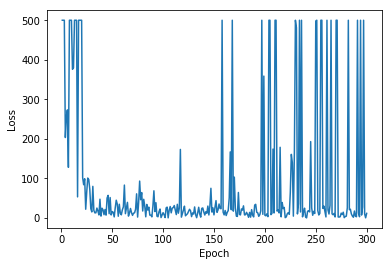

In [23]:
# plot training curve
scale = 500
train_curve = []
train_param = []
trials = client.list_trials(study_name)

for trial in trials:
    trial_metrics = client.list_trial_metrics(study_name,trial.id)
    train_param.append(ast.literal_eval(trial.parameter_values))
    for metrics in trial_metrics:
        train_curve.append(metrics.objective_value)
train_curve = np.clip(np.array(train_curve),0,scale)
best_trial = client.get_best_trial(study_name)
best_objval = round(best_trial.objective_value,3)
print("Is study done: %r"%client.is_study_done(study_name))
print("Best epoch: %d"%np.argmin(train_curve))
print("Best trial: {}".format(best_trial))

plt.plot(range(1,len(train_curve)+1),train_curve)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("./records/loss_"+str(best_objval)+"_"+str(scale)+".png")
plt.show()

max objval: 2.574


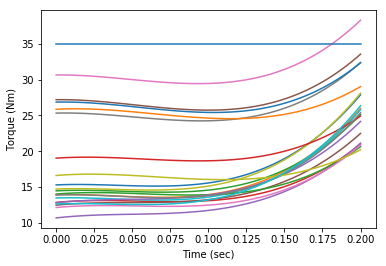

In [41]:
train_curve = np.array(train_curve)
topk_idx = np.argsort(train_curve)[:20]
print("max objval: %.3f"%max(train_curve[topk_idx]))
t = np.linspace(0,0.2,100)
y_constant = 35*np.ones_like(t)
for idx in topk_idx:
    param = train_param[idx]
    a = param["jump_a"]
    b = param["jump_b"]
    c = param["jump_c"]
    d = param["jump_d"]
    y_poly = (10*a * t + 100*b * t ** 2 + 1000*c * t ** 3 + 10*d)
    plt.plot(t,y_poly)
plt.plot(t,y_constant)
plt.xlabel("Time (sec)")
plt.ylabel("Torque (Nm)")
plt.show()

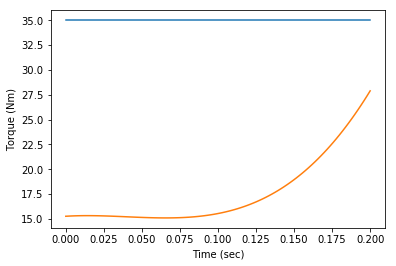

{'opt_vel': 3.8062331674253143, 'jump_d': 1.5275690521827014, 'jump_c': 3.3469197574928664, 'jump_b': -4.00570240001859, 'jump_a': 0.9329142174022049}


In [39]:
param_dic = ast.literal_eval(best_trial.parameter_values)
a = param_dic["jump_a"]
b = param_dic["jump_b"]
c = param_dic["jump_c"]
d = param_dic["jump_d"]
t = np.linspace(0,0.2,100)
y_constant = 35*np.ones_like(t)
y_poly = (10*a * t + 100*b * t ** 2 + 1000*c * t ** 3 + 10*d)

plt.plot(t,y_constant)
plt.plot(t,y_poly)
plt.xlabel("Time (sec)")
plt.ylabel("Torque (Nm)")
plt.savefig("./records/torque_"+str(best_objval)+".png")
plt.show()
print(param_dic)

In [46]:
with open("./controllers/my_controller_python/args.txt",'w') as f1:
    f1.write(str(param_dic))
with open("./records/args_"+str(best_objval)+".txt",'w') as f1:
    f1.write(str(param_dic))

os.system('webots --mode=pause')
with open("./controllers/my_controller_python/metrics.txt",'r') as f2:
    metrics_dic = eval(f2.read())
    y = metrics_dic["jump_metrics"]
print("objective_value:",y)

('objective_value:', 77.59320246449983)


In [45]:

for param,objval in zip(train_param,train_curve):
    param["objective_value"] = objval
with open("./records/args_"+str(best_objval)+".txt",'w') as f1:
    f1.write(str(train_param))